In [1]:
import CSV
import TypedTables: Table, columnnames

Load the isochrone table using `CSV.read` into a `TypedTables.Table` structure. This contains an isochrone table from PARSEC that has 26 steps in [M/H] and 71 steps in `logAge=log10(age [yr])` for a total of 1846 unique isochrones.

In [2]:
table = CSV.read("../../../../Work/Resources/isochrones/parsec/jwst/nircam_nov22/table.dat", Table; comment="#", delim=' ', ignorerepeated=true, 
    header=["Zini", "MH", "logAge", "Mini", "int_IMF", "Mass", "logL", "logTe", "logg", "label", "McoreTP", "C_O", "period0", "period1", "period2", 
        "period3", "period4", "pmode", "Mloss", "tau1m", "X",  "Y", "Xc",  "Xn",  "Xo",  "Cexcess",  "Z", "mbolmag",  "F070W",  "F090W",  "F115W",  
        "F150W",  "F200W",  "F277W",  "F356W",  "F444W",  "F150W2",  "F322W2",  "F140M",  "F162M",  "F182M",  "F210M",  "F250M",  "F300M",  "F335M",  
        "F360M",  "F410M",  "F430M",  "F460M",  "F480M"])

Table with 50 columns and 709192 rows:
      Zini       MH        logAge  Mini      int_IMF  Mass   logL    logTe   ⋯
    ┌─────────────────────────────────────────────────────────────────────────
 1  │ 2.4652e-5  -2.19174  6.6     0.1       1.17111  0.1    -1.436  3.5769  ⋯
 2  │ 2.4652e-5  -2.19174  6.6     0.105145  1.2127   0.105  -1.411  3.5791  ⋯
 3  │ 2.4652e-5  -2.19174  6.6     0.109821  1.24828  0.109  -1.387  3.5809  ⋯
 4  │ 2.4652e-5  -2.19174  6.6     0.124     1.34512  0.124  -1.321  3.5865  ⋯
 5  │ 2.4652e-5  -2.19174  6.6     0.129464  1.37867  0.129  -1.298  3.5885  ⋯
 6  │ 2.4652e-5  -2.19174  6.6     0.140418  1.4407   0.14   -1.252  3.5923  ⋯
 7  │ 2.4652e-5  -2.19174  6.6     0.149107  1.4856   0.149  -1.219  3.595   ⋯
 8  │ 2.4652e-5  -2.19174  6.6     0.183261  1.63379  0.182  -1.1    3.6048  ⋯
 9  │ 2.4652e-5  -2.19174  6.6     0.197245  1.68445  0.196  -1.057  3.6085  ⋯
 10 │ 2.4652e-5  -2.19174  6.6     0.207292  1.71805  0.206  -1.029  3.6111  ⋯
 11 │ 2.4652e

Check the available columns in the table

In [3]:
columnnames(table)

(:Zini, :MH, :logAge, :Mini, :int_IMF, :Mass, :logL, :logTe, :logg, :label, :McoreTP, :C_O, :period0, :period1, :period2, :period3, :period4, :pmode, :Mloss, :tau1m, :X, :Y, :Xc, :Xn, :Xo, :Cexcess, :Z, :mbolmag, :F070W, :F090W, :F115W, :F150W, :F200W, :F277W, :F356W, :F444W, :F150W2, :F322W2, :F140M, :F162M, :F182M, :F210M, :F250M, :F300M, :F335M, :F360M, :F410M, :F430M, :F460M, :F480M)

In [4]:
unique(table.MH) # These are metallicities, [M/H]

26-element Vector{Float64}:
 -2.19174
 -2.1
 -2.0
 -1.9
 -1.8
 -1.7
 -1.6
 -1.5
 -1.4
 -1.3
 -1.2
 -1.1
 -1.0
 -0.9
 -0.8
 -0.7
 -0.6
 -0.5
 -0.4
 -0.3
 -0.2
 -0.1
  0.0
  0.1
  0.2
  0.3

In [5]:
unique(table.logAge) # These are `log10(age)`, where the age is in years.

71-element Vector{Float64}:
  6.6
  6.65
  6.7
  6.75
  6.8
  6.85
  6.9
  6.95
  7.0
  7.05
  7.1
  7.15
  7.2
  ⋮
  9.55001
  9.60001
  9.65001
  9.70001
  9.75001
  9.80001
  9.85001
  9.90001
  9.95001
 10.00001
 10.05001
 10.10001

We'll construct a model Hess diagram from the populations in this isochrone table. First we need to set up our observational models for photometric error and incompleteness. You would typically measure these from artificial star tests but we'll make up some models here using functions built into StarFormationHistories.jl.

In [6]:
import StarFormationHistories: Martin2016_complete, exp_photerr

In [7]:
distmod = 25.0 # Distance modulus 
F090W_complete(m) = Martin2016_complete(m,1.0,28.5,0.7)
F150W_complete(m) = Martin2016_complete(m,1.0,27.5,0.7)
F090W_error(m) = min( exp_photerr(m, 1.03, 15.0, 36.0, 0.02), 0.4 )
F150W_error(m) = min( exp_photerr(m, 1.03, 15.0, 35.0, 0.02), 0.4 )

F150W_error (generic function with 1 method)

We'll make a few plots showing the adopted models. Below we set up PyPlot.jl (a wrapper for Python's matplotlib package).

In [8]:
import PyPlot as plt
import PyPlot: @L_str # For LatexStrings
import PyCall: @pyimport
plt.rc("text", usetex=true)
plt.rc("font", family="serif", serif=["Computer Modern"], size=14)
plt.rc("figure", figsize=(5,5))
plt.rc("patch", linewidth=1, edgecolor="k", force_edgecolor=true) 

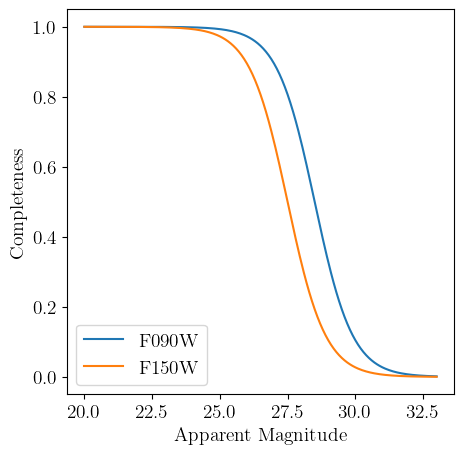

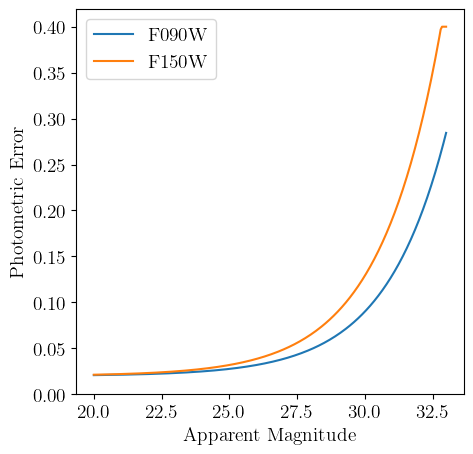

(0.0, 0.41895850114873723)

In [9]:
plotmags=20.0:0.05:33.0

fig,ax1=plt.subplots()
ax1.plot(plotmags,F090W_complete.(plotmags),label="F090W")
ax1.plot(plotmags,F150W_complete.(plotmags),label="F150W")
ax1.set_xlabel("Apparent Magnitude")
ax1.set_ylabel("Completeness")
ax1.legend(loc="lower left")

plotmags=20.0:0.05:33.0
fig,ax1=plt.subplots()
ax1.plot(plotmags,F090W_error.(plotmags),label="F090W")
ax1.plot(plotmags,F150W_error.(plotmags),label="F150W")
ax1.set_xlabel("Apparent Magnitude")
ax1.set_ylabel("Photometric Error")
ax1.legend(loc="upper left")
ax1.set_ylim([0.0,ax1.get_ylim()[2]])

We put a maximum on the magnitude error in the model because most of the time one would place a cut on the photometric catalog in either signal to noise (e.g., SNR>5) or magnitude error (e.g., error < 0.4). From a practical perspective, if we allow the photometric error model to grow too large, it will hurt the efficiency of `partial_cmd_smooth` for template creation later.

We may now define our mock star formation history. We will use `partial_cmd_smooth` to construct the templates for a Hess diagram model with F150W on the y-axis and F090W-F150W on the x-axis, with an initial mass function model from InitialMassFunctions.jl. We'll construct all 1846 templates, one for every isochrone in our table, but this may not always be necessary.

In [10]:
import StarFormationHistories: partial_cmd_smooth
import InitialMassFunctions: Kroupa2001

[ Info: Precompiling InitialMassFunctions [e9251ff4-c148-4db3-bf46-89407750fae0]


In [11]:
# Some additional setup
imf = Kroupa2001(0.08, 100.0) # Initial mass function model
unique_logAge = unique(table.logAge)
unique_MH = unique(table.MH)
template_norm = 1e3 # The stellar mass of the populations in each template
edges = (range(-0.5, 1.6, length=100), range(distmod-8.0, distmod+3.0, length=100)) # The bin edges for the Hess diagrams (17,28)

(-0.5:0.021212121212121213:1.6, 17.0:0.1111111111111111:28.0)

In [12]:
# Constructing the templates
templates = Vector{Matrix{Float64}}(undef,0)
template_logAge = Vector{Float64}(undef,0)
template_MH = Vector{Float64}(undef,0)
# We don't strictly need to save the initial masses (m_ini) or the isochrone magnitudes (iso_mags), 
# but we'll use them later in this example so we'll save them now. 
template_mini = Vector{Vector{Float64}}(undef,0)
template_isomags = Vector{Vector{Vector{Float64}}}(undef,0)
for logage in unique_logAge 
    for mh in unique_MH
        # Combination of a logage and an MH defines a unique isochrone.
        # Pick out all entries in `table` that match this combination; these will be row indices
        # into the table of the stars in this specific isochrone.
        local good = findall( (table.MH .== mh) .& (table.logAge .== logage) )
        # Chop off the last entry in the isochrone because its the 30 mag weird thing that parsec does.
        local m_ini = table.Mini[good][begin:end-1] # These are the initial masses of the stars in the isochrone, in solar masses.
        push!(template_mini, m_ini)
        local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]] # These are the absolute magnitudes we want from the isochrone.
        push!(template_isomags, iso_mags)
        # Create template and push
        push!(templates, partial_cmd_smooth( m_ini, iso_mags, [F090W_error, F150W_error], 2, [1,2], imf, [F090W_complete, F150W_complete]; 
                dmod=distmod, normalize_value=template_norm, edges=edges).weights )
        push!(template_logAge, logage)
        push!(template_MH, mh)
    end
end

In [13]:
# Sort the template_logAge and template_MH so we have a guarantee for later
permidx = sortperm(template_logAge)
template_logAge = template_logAge[permidx]
template_MH = template_MH[permidx]
templates = templates[permidx]

1846-element Vector{Matrix{Float64}}:
 [0.0 5.308707755624576e-10 … 0.0 0.0; 6.906811253133398e-14 1.5108610725823887e-8 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 

We'll plot a few templates for reference.

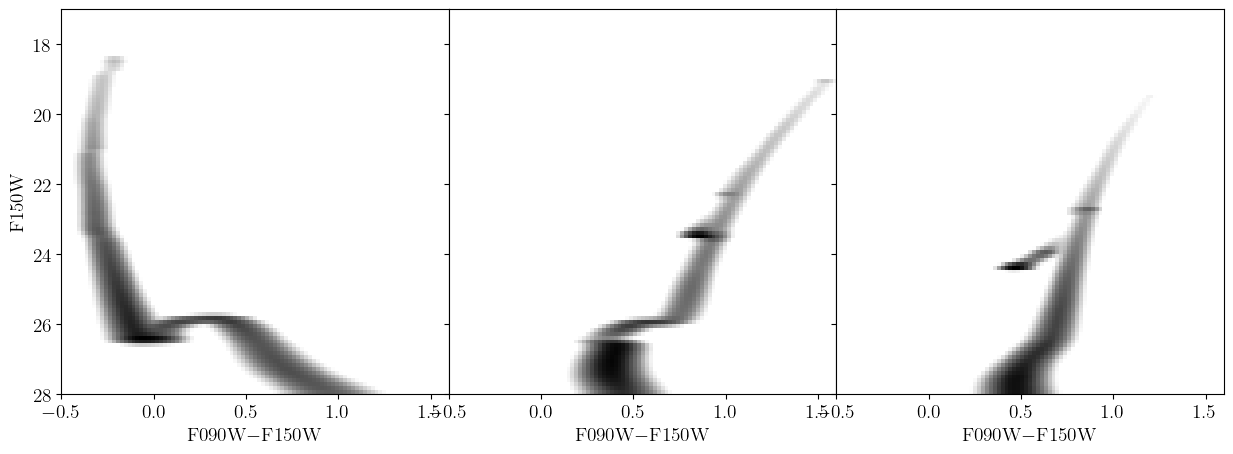

(-0.5, 1.6)

In [14]:
fig,axs=plt.subplots(1,3,sharey=true,figsize=(15,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

axs[1].imshow(permutedims(templates[100]), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=0.0005), rasterized=true) 
axs[2].imshow(permutedims(templates[1500]), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=0.0005), rasterized=true) 
axs[3].imshow(permutedims(templates[1800]), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=0.0005), rasterized=true) 
# im1.set_clim( [0.5, im1.get_clim()[2]] )
axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[3].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))

We may now use `construct_x0_mdf` and `calculate_coeffs_mdf` to create a mock star formation history with constant star formation rate and a reasonable metallicity evolution for a dwarf galaxy. 

In [15]:
import StarFormationHistories: construct_x0_mdf, calculate_coeffs_mdf

In [16]:
# Set overall stellar mass of complex population and the metallicity evolution variables
stellar_mass = 1e7
α, β, σ = -0.1, -0.5, 0.3
# We have to divide `stellar_mass` by `template_norm` here because `template_norm` is the total amount of stellar mass in each template, since we passed `normalize_value=template_norm` 
# when constructing the templates with `partial_cmd_smooth`. As such, when computing coefficients, we need to normalize out the adopted `normalize_value` for the templates.
x0_mdf = construct_x0_mdf(template_logAge; normalize_value=stellar_mass / template_norm)

71-element Vector{Float64}:
    3.1632043225667794
    0.38596939903202293
    0.4330647885097611
    0.4859066846163288
    0.5451962672082045
    0.6117202730241489
    0.6863614352037445
    0.7701101966197678
    0.8640778524534942
    0.9695112964064287
    1.0878095662222338
    1.220542408067581
    1.3694711061099618
    ⋮
  306.5934508845192
  344.0035098605409
  385.97828640818756
  433.0747603098365
  485.91787316001796
  545.2088209607206
  611.7343585661209
  686.3772394417871
  770.1279292665228
  864.0977488103649
  969.533620486047
 1087.8346142515018

The above coefficients are the amount of stellar mass formed in each age bin of `unique(template_logAge)`. To construct the complex Hess diagram, we need individual per-template weights, which we can get with `calculate_coeffs_mdf`.

In [17]:
x0 = calculate_coeffs_mdf(x0_mdf, template_logAge, template_MH, α, β, σ)

1846-element Vector{Float64}:
 5.2829726543486186e-8
 2.826921183569167e-7
 1.5815145856142794e-6
 7.917312015023231e-6
 3.5467238629346465e-5
 0.00014217461175929075
 0.0005099901434393602
 0.0016369920555552111
 0.004701932806375619
 0.012085129897158828
 0.027795294805119823
 0.05720530481915483
 0.10535287243213265
 ⋮
 0.9184532583057752
 0.29935512265025405
 0.08730947705594681
 0.02278668439692459
 0.005321645552722102
 0.001112130651303691
 0.0002079748086561259
 3.480252177916151e-5
 5.211416120029412e-6
 6.983061190509914e-7
 8.372998258276432e-8
 8.983823513353381e-9

Let's plot the cumulative SFH and mean [M/H] of our model population.

In [18]:
import StarFormationHistories: calculate_cum_sfr
unique_template_logAge, cum_sfr_arr, sfr_arr, mean_mh_arr = calculate_cum_sfr(x0, template_logAge, template_MH; normalize_value=template_norm)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [0.9999999999999997, 0.9996837795947182, 0.9996451948599551, 0.9996019020754964, 0.9995533267723956, 0.9994988243858933, 0.9994376717024342, 0.999369057263063, 0.9992920705958569, 0.9992056901345163  …  0.6837722340374748, 0.6451866108176718, 0.6018928294943103, 0.553316407892987, 0.49881276641234773, 0.4376586748444147, 0.3690426555491192, 0.29205421563905803, 0.20567176529205472, 0.1087490618748904], [0.0007945610017947954, 0.0007945612013795453, 0.0007945612013795453, 0.0007945612013795455, 0.0007945612013795449, 0.0007945612013795455, 0.0007945612013795454, 0.0007945612013795451, 0.0007945612013795454, 0.0007945612013795456  …  0.0007945612013795454, 0.0007945612013795456, 0.0007945612013795455, 0.0007945612013795456, 0.0007945612013795453, 0.0007945612013795451, 0.0007945612013795453, 0.0007945612013795456, 0.0007945612013795455,

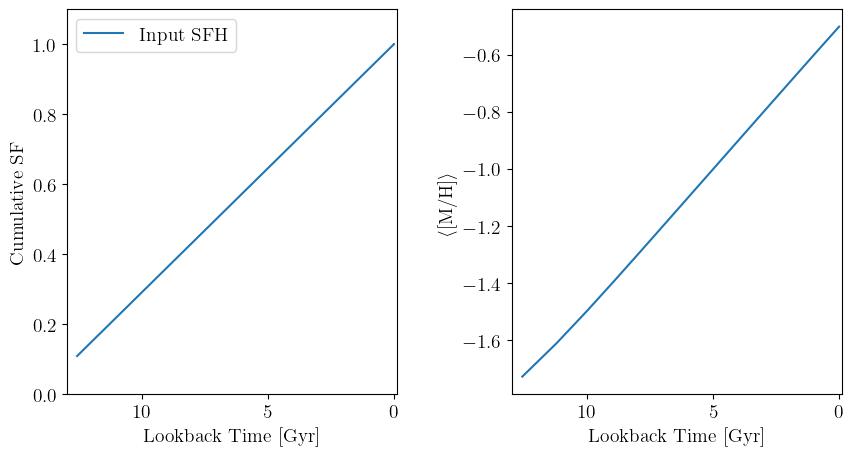

PyObject Text(457.3650849792141, 0.5, '$\\langle$[M/H]$\\rangle$')

In [19]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="Input SFH" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")

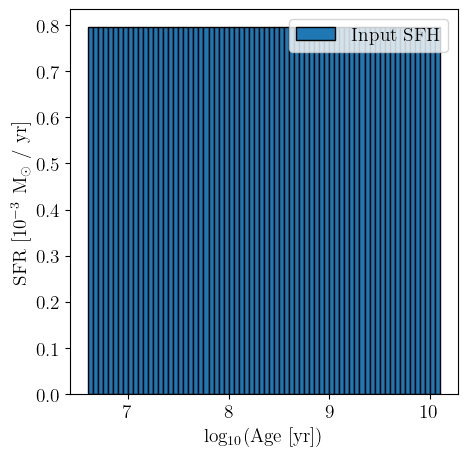

PyObject <matplotlib.legend.Legend object at 0x7f03c1500eb0>

In [58]:
fig,ax1 = plt.subplots()
ax1.bar(unique_template_logAge[begin:end-1], sfr_arr[begin:end-1] .* 1e3; width=diff(unique_template_logAge), align="edge", label="Input SFH")
ax1.set_xlabel(L"log$_{10}$(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

Now let's make a model Hess diagram with this SFH. We can simply write `composite = sum( coeffs .* models)` if we want, but we also provide the `composite!` function that is more efficient.

In [65]:
@time model1 = sum( x0 .* templates)

  0.088524 seconds (7.45 k allocations: 276.379 MiB, 59.57% gc time)


99×99 Matrix{Float64}:
 0.0          2.80458e-17  6.82329e-16  …  0.0          0.0
 3.64885e-21  7.98184e-16  1.67736e-14     0.0          0.0
 8.63848e-19  1.37904e-14  2.43507e-13     1.55169e-20  0.0
 4.04661e-17  1.49166e-13  2.09544e-12     1.13733e-14  2.57145e-17
 1.44039e-15  1.07941e-12  1.07478e-11     6.14054e-11  5.83515e-13
 9.5321e-12   4.8643e-11   5.11416e-11  …  5.54255e-9   7.76611e-11
 9.58498e-10  6.00513e-9   2.46369e-8      9.77816e-8   2.40016e-9
 4.26846e-8   1.85007e-7   6.73909e-7      7.9791e-7    3.21385e-8
 9.23827e-7   3.42256e-6   1.09591e-5      4.35873e-6   2.45304e-7
 1.24642e-5   3.91084e-5   0.000107173     1.88969e-5   1.29223e-6
 0.000104134  0.000274419  0.000635197  …  7.10267e-5   5.47169e-6
 0.000539639  0.00118578   0.00230891      0.000239762  1.9947e-5
 0.00175648   0.00319153   0.00524382      0.000745471  6.59014e-5
 ⋮                                      ⋱               
 0.0343291    0.0396613    0.0395587       0.000613508  0.000973286


In [66]:
model2 = similar(model1)
import StarFormationHistories: composite!
@time composite!(model2, x0, templates)
model2

  0.008725 seconds


99×99 Matrix{Float64}:
 0.0          2.80458e-17  6.82329e-16  …  0.0          0.0
 3.64885e-21  7.98184e-16  1.67736e-14     0.0          0.0
 8.63848e-19  1.37904e-14  2.43507e-13     1.55169e-20  0.0
 4.04661e-17  1.49166e-13  2.09544e-12     1.13733e-14  2.57145e-17
 1.44039e-15  1.07941e-12  1.07478e-11     6.14054e-11  5.83515e-13
 9.5321e-12   4.8643e-11   5.11416e-11  …  5.54255e-9   7.76611e-11
 9.58498e-10  6.00513e-9   2.46369e-8      9.77816e-8   2.40016e-9
 4.26846e-8   1.85007e-7   6.73909e-7      7.9791e-7    3.21385e-8
 9.23827e-7   3.42256e-6   1.09591e-5      4.35873e-6   2.45304e-7
 1.24642e-5   3.91084e-5   0.000107173     1.88969e-5   1.29223e-6
 0.000104134  0.000274419  0.000635197  …  7.10267e-5   5.47169e-6
 0.000539639  0.00118578   0.00230891      0.000239762  1.9947e-5
 0.00175648   0.00319153   0.00524382      0.000745471  6.59014e-5
 ⋮                                      ⋱               
 0.0343291    0.0396613    0.0395587       0.000613508  0.000973286


In [67]:
model1 ≈ model2

true

Let's plot the smooth model.

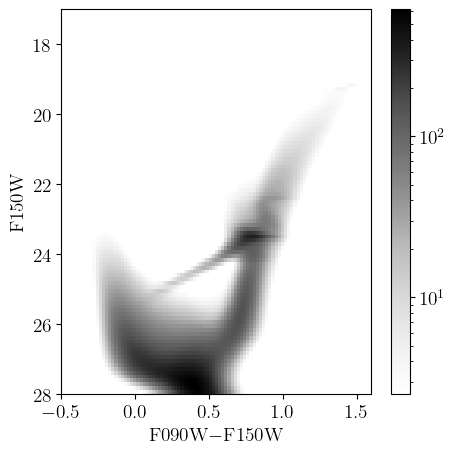

PyObject <matplotlib.colorbar.Colorbar object at 0x7f04374f33d0>

In [38]:
fig,ax1=plt.subplots()

im1=ax1.imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
ax1.set_xlabel(L"F090W$-$F150W")
ax1.set_ylabel("F150W")
ax1.set_ylim(reverse(extrema(edges[2]))) 
ax1.set_xlim(extrema(edges[1]))
fig.colorbar(im1)

The templates are constructed such that the 2D histogram pixel values give the expected number of stars in that bin for a population with total stellar mass `normalize_value` (in our case we defined the variable `template_norm=1e3` and used that as our `normalize_value` for the templates). As such the pixel values of this complex model also represent expected numbers of stars per bin for our defined SFH. We may, therefore, simply Poisson sample it to obtain a reasonable observational realization of the Hess diagram:

In [139]:
import Distributions: Poisson
import Random: AbstractRNG, default_rng
function poisson_sample!(sample::T, model::S, rng::AbstractRNG=default_rng()) where {T <: AbstractArray{<:Number}, S <: AbstractArray{<:Number}}
    @assert axes(sample) == axes(model)
    for i in eachindex(sample, model)
        sample[i] = rand(rng,Poisson(model[i]))
    end
end
poisson_sample(model::AbstractArray{<:Number}, rng::AbstractRNG=default_rng()) = (sample = similar(model); poisson_sample!(sample, model, rng); return sample)
model3 = poisson_sample(model2)

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

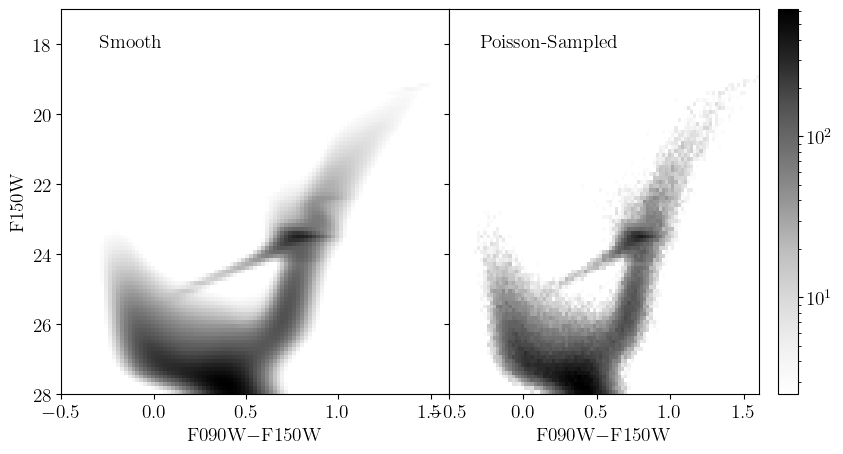

PyObject <matplotlib.colorbar.Colorbar object at 0x7f03c18fa410>

In [59]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

im1=axs[1].imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
axs[1].text(0.1,0.9,"Smooth",transform=axs[1].transAxes)
axs[2].imshow(permutedims(model3), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true) 
axs[2].text(0.1,0.9,"Poisson-Sampled",transform=axs[2].transAxes)
axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))
fig.colorbar(im1, ax=axs[2])

To sample the color-magnitude diagram (CMD) directly we could use `generate_stars_mass_composite`,

In [27]:
import StarFormationHistories: generate_stars_mass_composite, NoBinaries
starcat = generate_stars_mass_composite(template_mini, template_isomags, ["F090W", "F150W"], stellar_mass, x0, imf; dist_mod=distmod, binary_model=NoBinaries())

([[0.1128507348807242], [0.3506954967445645], [0.2911718468147568], [0.53411423292032], [0.4776182080834065], [0.2564004299163085], [0.10190775523742387, 0.10381047207191368, 0.14998416835803666, 0.14996476835062478, 1.037198187613003], [0.35766569320323227, 0.1683634075991572, 1.3538456235124516], [0.460024018861662, 0.5226932218541293, 0.09081624929055468, 0.35776614115481853, 0.1752841893622473, 3.209514126604863], [0.09115313170716416, 0.1541723910921088, 0.2598057373262478, 0.35006503959525387, 3.0224508954188885, 0.9535305369206668, 0.13983656363671934, 0.11633319429525832, 0.18755078879656778, 0.9058474036162786  …  0.5335097139629881, 0.2117081727376559, 0.10338890069288756, 0.11751541491127926, 1.0861310259347017, 0.22428511253317926, 0.0941660238974653, 0.7469913471116436, 0.4867999151164247, 2.469983129024484]  …  [0.2307669787587578, 0.21966391216288064, 0.502581936840645, 0.13994185522540356, 0.26182430277394664, 0.4971320422047196, 0.15881584165901896, 0.5930459709024063,

We'll concatenate the per-population samples returned from `generate_stars_mass_composite` into a single `Vector{SVector}`. 

In [30]:
# starcat_mags = reduce(hcat,reduce(vcat,starcat[2])) # For 2D matrix
starcat_mags = reduce(vcat,starcat[2])

14720737-element Vector{StaticArraysCore.SVector{2, Float64}}:
 [32.229252582905325, 31.135875663893316]
 [30.639385632101398, 29.663214989057927]
 [30.936561418508397, 29.89858160851672]
 [29.98324922308923, 29.093217324533228]
 [30.19330686619155, 29.230635081776573]
 [31.16706204502066, 30.052411595749998]
 [32.448263029125535, 31.254352225335087]
 [32.42558608901555, 31.232761605709413]
 [31.94004342438123, 30.769485274564552]
 [31.940215106890186, 30.769649445963744]
 [28.435902787757588, 27.794013970383638]
 [30.741821529837665, 29.628498469195037]
 [31.804193878228645, 30.630647619680072]
 ⋮
 [34.35420559327128, 33.108855746761634]
 [31.513444042706503, 30.399926580352876]
 [32.01727975119181, 30.862474987274084]
 [35.56357509539067, 34.164998403726216]
 [33.39594300530596, 32.16602911091906]
 [34.17567152904134, 32.90561635977233]
 [33.6952761666459, 32.415999535044065]
 [33.67410183060131, 32.357705377515856]
 [36.172879518868776, 34.49491227472797]
 [35.53508739086994, 33.941

Now we'll mock observe the "pure" catalog with the same observational models we used to construct the templates using `model_cmd`.

In [29]:
import StarFormationHistories: model_cmd
obs_mags = model_cmd( starcat_mags, [F090W_error, F150W_error], [F090W_complete, F150W_complete] )

208237-element Vector{StaticArraysCore.SVector{2, Float64}}:
 [27.041463686311936, 26.61947885246515]
 [26.193699006689094, 26.318315261268467]
 [28.756312803867594, 28.067603800687447]
 [28.394117445245886, 27.765571462888836]
 [26.673880377495887, 26.839889547926308]
 [26.073625569188383, 26.228044722268823]
 [26.205864856000552, 26.436184848181504]
 [27.98248180366743, 27.33101930586727]
 [21.404937981181284, 21.742261456854788]
 [26.197068945930752, 26.340028079348446]
 [26.93142996350409, 27.128047987494288]
 [26.587191099862014, 26.795695506845444]
 [24.678534789366644, 24.906094999585815]
 ⋮
 [27.60255388896001, 27.003547936005507]
 [28.011617083411398, 27.475783812392002]
 [24.37268441583131, 23.558382703752404]
 [23.600878992887644, 22.566264488090294]
 [26.93484001913034, 26.209637715676806]
 [28.116665550487443, 27.713522346001277]
 [27.779976904031685, 27.15476990367181]
 [29.329004068527503, 28.756001030809774]
 [26.18098046143057, 25.361433908459848]
 [28.58888173342272, 

Now we'll compute the Hess diagram with `bin_cmd` and compare with our smooth and Poisson-sampled versions. 

In [44]:
# Concatenate into 2D matrix
obs_mags = reduce(hcat,obs_mags)

2×208237 Matrix{Float64}:
 27.0415  26.1937  28.7563  28.3941  …  26.181   28.5889  28.9624  24.638
 26.6195  26.3183  28.0676  27.7656     25.3614  28.2139  28.5181  23.9018

In [46]:
import StarFormationHistories: bin_cmd
model4 = bin_cmd(view(obs_mags,1,:) .- view(obs_mags,2,:), view(obs_mags,2,:), edges=edges).weights

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

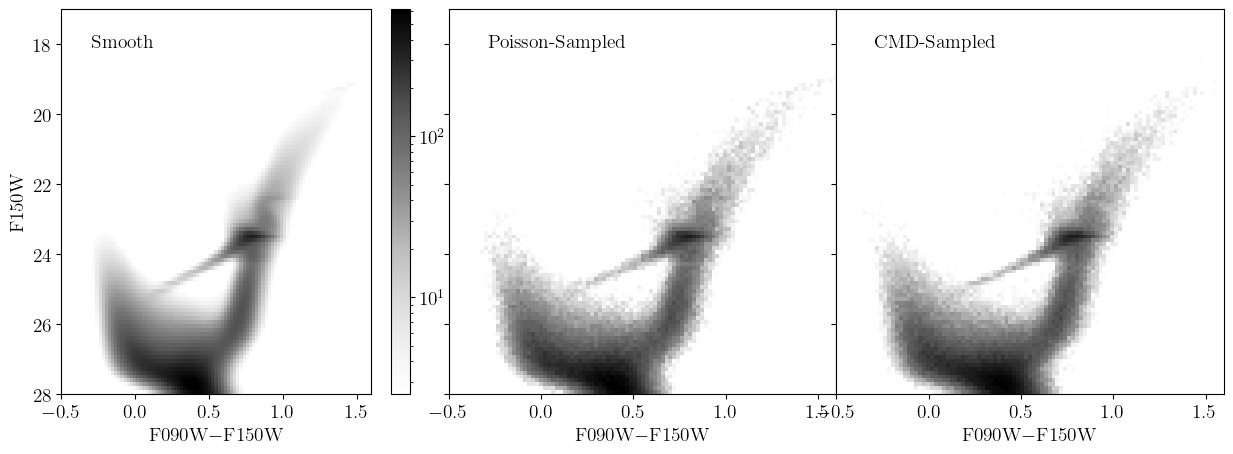

PyObject <matplotlib.colorbar.Colorbar object at 0x7f03c0f96290>

In [60]:
fig,axs=plt.subplots(nrows=1,ncols=3,sharex=true,sharey=true,figsize=(15,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

im1=axs[1].imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
axs[1].text(0.1,0.9,"Smooth",transform=axs[1].transAxes)
axs[2].imshow(permutedims(model3), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true) 
axs[2].text(0.1,0.9,"Poisson-Sampled",transform=axs[2].transAxes)
axs[3].imshow(permutedims(model4), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true, label="CMD-Sampled") 
axs[3].text(0.1,0.9,"CMD-Sampled",transform=axs[3].transAxes)

axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[3].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))
fig.colorbar(im1)

The mock Hess diagram created by Poisson-sampling the smooth model (labelled "Poisson-Sampled") and the Hess diagram created by sampling stars via `generate_stars_mass_composite` and mock observing them with `model_cmd` (labelled "CMD-Sampled") are highly consistent. The Poisson-sampled method is more efficient if a Hess diagram is all that is required, but if you need individual stars (e.g., for forming a star catalog for injection into images) then you should go the CMD-sampled route.

We will now explore the methods offered to fit SFHs. We will adopt the Poisson-sampled model Hess diagram above for this purpose.

In [140]:
data = model3

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

The best way to fit this SFH would be to use `fit_templates_mdf` as it uses the same hierarchical model as we used to generate the SFH (fitting stellar masses per bin in logage, and a mean metallicity relation with Gaussian scatter). We will first show how to use some of the simpler fitting methods that fit per-template stellar masses. These methods are generally most useful when you have a smaller set of templates that you want to use to fit the SFH. For this purpose, we will create a smaller grid of templates centered around a reasonable (but not exactly correct) metallicity evolution; we will accept any isochrone within ± 0.2 dex of this metallicity evolution guess.

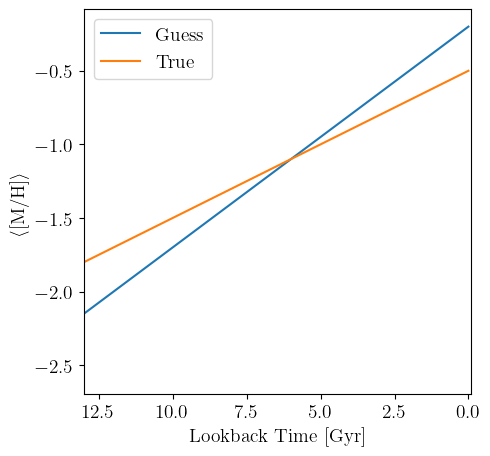

PyObject <matplotlib.legend.Legend object at 0x7f03c08fff40>

In [78]:
new_α, new_β, new_σ = -0.15, -0.2, 0.2
met_func(logAge) = exp10(logAge) * new_α / 1e9 + new_β
met_func_true(logAge) = exp10(logAge) * α / 1e9 + β
laxplot = 6.6:0.01:10.2
fig,ax1=plt.subplots()
ax1.plot(exp10.(laxplot)./1e9, met_func.(laxplot),label="Guess")
ax1.plot(exp10.(laxplot)./1e9, met_func_true.(laxplot),label="True")
ax1.set_xlim([13.0,-0.1])
ax1.set_xlabel("Lookback Time [Gyr]")
ax1.set_ylabel(L"$\langle$[M/H]$\rangle$")
ax1.legend(loc="upper left")

Now create the limited template set.

In [79]:
free_templates = Vector{Matrix{Float64}}(undef,0)
free_template_logAge = Vector{Float64}(undef,0)
free_template_MH = Vector{Float64}(undef,0)
for logage in unique_logAge
    mean_met = met_func(logage)
    for mh in unique_MH
        # If the current mh is more than `new_σ` dex away from mean, skip template
        abs(mh - mean_met) > new_σ && continue
        local good = findall( (table.MH .== mh) .& (table.logAge .== logage) )
        # Chop off the last star because its the 30 mag weird thing that parsec does.
        local m_ini = table.Mini[good][begin:end-1]
        local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]]
        push!(free_templates, partial_cmd_smooth( m_ini, iso_mags, [F090W_error, F150W_error], 2, [1,2], imf, [F090W_complete, F150W_complete]; 
                dmod=distmod, normalize_value=template_norm, edges=edges).weights )
        push!(free_template_logAge, logage)
        push!(free_template_MH, mh)
    end
end

In [82]:
# `templates` has 1846 entries, free_templates has ~10% of that.
length(free_templates)

284

Let's start off by just obtaining the maximum likelihood estimate (MLE) via `fit_templates_lbfgsb`. We'll construct the initial guess vector `x0` with `construct_x0`.

In [141]:
import StarFormationHistories: fit_templates_lbfgsb, construct_x0
lbfgsb_result = fit_templates_lbfgsb(free_templates, data; x0=construct_x0(free_template_logAge; normalize_value=template_norm))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          284     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  284   9871  10564  10169     0   209   8.466D-06   1.232D+04

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 Total User time 1.816E+01 seconds.



(12315.28404630495, [2.4609718165471244, 0.0, 0.0, 3.405749009538802, 0.0, 0.0, 0.0, 1.3649923411053595, 0.0, 0.0  …  231.44021367305763, 576.3571535982603, 103.76379539879905, 122.30704605334937, 306.8760694234976, 457.6179177798743, 692.2336054641534, 0.0, 244.46001697264026, 343.1275786544997])

In [142]:
free_coeffs = lbfgsb_result[2] .* template_norm
unique_free_template_logAge, free_cum_sfr_arr, free_sfr_arr, free_mean_mh_arr = calculate_cum_sfr(free_coeffs, free_template_logAge, free_template_MH)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [1.0000000000000002, 0.9994086680254276, 0.9992710845882282, 0.9992710845882282, 0.9992710845882282, 0.9992710845882282, 0.9992710845882282, 0.9992710845882282, 0.9992710845882282, 0.9992710845882282  …  0.6619592841280152, 0.6619592841280152, 0.6619592841280152, 0.5798907323730059, 0.547340132281431, 0.5440484319304831, 0.45219695517573666, 0.3174075279348782, 0.22884195342015898, 0.12899867240591079], [0.0014736536440499925, 0.0028099894891733847, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0013313900590829352, 0.00047063859602206114, 4.2417867788064156e-5, 0.0010549082371025156, 0.0013796990593992603, 0.0008079667421440265, 0.0008117968925165093, 0.0009347894043524244], [-0.22584398795343738, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1  …  -0.6, -0.6, -1.1526353040838182, -1.3, -1.4, -1.2, -1.4573043106084753, -

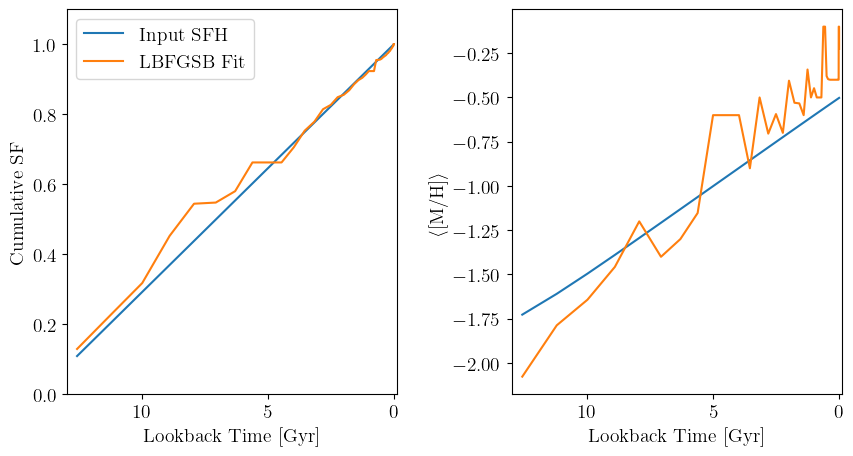

PyObject Text(447.8810729977773, 0.5, '$\\langle$[M/H]$\\rangle$')

In [144]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
axs[1].plot( exp10.(unique_free_template_logAge)./1e9, free_cum_sfr_arr, label="LBFGSB Fit" )

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="Input SFH" )
axs[2].plot( exp10.(unique_free_template_logAge)./1e9, free_mean_mh_arr, label="LBFGSB Fit" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")

We can also use `fit_templates`, which uses BFGS to build a dense estimate of the inverse Hessian. This function has worse scaling with the number of templates than `fit_templates_lbfgsb` above, but allows for estimation of random uncertainties.

In [145]:
import LinearAlgebra: BLAS
BLAS.set_num_threads(1) # BFGS uses BLAS operations, but they are relatively small so it's actually more efficient to run BLAS single-threaded.
import StarFormationHistories: fit_templates
bfgs_result = fit_templates(free_templates, data; x0=construct_x0(free_template_logAge; normalize_value=template_norm))

(map = (μ = [0.4501658034363217, 0.3760950455889681, 0.46635253838410523, 2.3158560500917504, 0.32764465490987, 0.2571428078148967, 0.2659084941786843, 1.05046133989828, 0.30063499271170274, 0.2079151728153511  …  225.55172872291354, 577.7075573326899, 108.94426045365724, 130.30997078964546, 312.56700742282743, 461.1673536549561, 639.2455998259281, 47.24945597535135, 205.73604664748584, 357.0683950443281], σ = [0.4070066726942965, 0.35805093554997774, 0.44328396977368284, 0.8084673455490212, 0.3171748788346782, 0.253553869061339, 0.26308545026409164, 0.6242082219163599, 0.2939851807974065, 0.2059413337149897  …  43.237684816822345, 54.30439108106269, 31.144662503856484, 32.573001234628194, 41.71323660268931, 56.289129834547836, 96.27555462062885, 40.52926810769506, 77.66092607103748, 63.934163381249896], invH = [0.8174440869666624 -0.09351065124713456 … 0.0017460054180384408 -0.0017841183166055444; -0.09351065124713459 0.9063467899339992 … 0.0005716530340211051 0.0007807807206743067; …

`bfgs_result.mle` contains information for the maximum likelihood estimate; this is most similar to what is returned by `fit_templates_lbfgsb` but not exactly equal.

In [146]:
bfgs_result.mle.μ .- lbfgsb_result[2]

284-element Vector{Float64}:
  2.090755484518425e-5
  1.0222501620116248e-163
  1.1695339267683565e-180
  5.7061129152824464e-5
  2.755291736326537e-72
  1.0991842391032032e-206
  1.1895846074838723e-241
  0.00011954351481668901
  1.7196107370411727e-56
  1.2556219828662676e-230
  1.8347657690595852e-286
  9.27431155070991e-306
  1.1740432715197228e-197
  ⋮
  1.220955770981363e-276
 -0.00015060218366613753
  0.0052570076123288345
 -0.0005885745791829322
  0.0024949823033182383
  0.0008140398789322489
  0.0048823453957425045
 -0.0034474194421250104
 -0.0017033230403740163
  1.163229642856685e-120
 -0.017047341655427317
  0.011733590816334072

Of additional note are the uncertainty estimates, available as `bfgs_result.map.σ` and `bfgs_result.mle.σ`. The `bfgs_result.map` result contains the maximum a posteriori result and is often very comparable to the results of posterior sampling via Hamiltonian Monte Carlo provided by `hmc_sample`. We don't generally recommend the use of `bfgs_result.mle.σ`, but provide it for completeness.

In [147]:
bfgs_result.map.μ

284-element Vector{Float64}:
   0.4501658034363217
   0.3760950455889681
   0.46635253838410523
   2.3158560500917504
   0.32764465490987
   0.2571428078148967
   0.2659084941786843
   1.05046133989828
   0.30063499271170274
   0.2079151728153511
   0.17967097328048545
   0.18314599282277683
   0.2197170099711491
   ⋮
   7.219589345860929
  77.32283019200077
 225.55172872291354
 577.7075573326899
 108.94426045365724
 130.30997078964546
 312.56700742282743
 461.1673536549561
 639.2455998259281
  47.24945597535135
 205.73604664748584
 357.0683950443281

In [148]:
bfgs_result.map.σ

284-element Vector{Float64}:
  0.4070066726942965
  0.35805093554997774
  0.44328396977368284
  0.8084673455490212
  0.3171748788346782
  0.253553869061339
  0.26308545026409164
  0.6242082219163599
  0.2939851807974065
  0.2059413337149897
  0.17863057830722803
  0.18237598508967567
  0.2175620633603133
  ⋮
  6.839199812265132
 39.00300888137966
 43.237684816822345
 54.30439108106269
 31.144662503856484
 32.573001234628194
 41.71323660268931
 56.289129834547836
 96.27555462062885
 40.52926810769506
 77.66092607103748
 63.934163381249896

Another thing we can do is draw samples from the posterior approximating the posterior distributions as Gaussians and the inverse Hessian as its variance-covariance matrix. There are additional notes in the documentation on this approximation, but it often reproduces results from more expensive Monte Carlo sampling methods fairly well.

In [174]:
import Distributions: MvNormal # multivariate normal distribution
import Optim
import LinearAlgebra: Hermitian 
import Statistics: median, quantile

# Generate sample from the inverse Hessian matrix
hessian_dist = MvNormal(Optim.minimizer(bfgs_result.map.result),
                        Hermitian(bfgs_result.map.invH))
hessian_sample = exp.(rand(hessian_dist, 10000)) .* template_norm
# Calculate the cumulative SFH for each sample
# and find the 1-σ quantile range for both the cumulative SFH and the SFRs
hessian_cum_sfr = Vector{Vector{Float64}}(undef,0)
hessian_sfr = Vector{Vector{Float64}}(undef,0)
for x in eachcol(hessian_sample)
    _, hessian_1, hessian_2, hessian_mh = calculate_cum_sfr(x, free_template_logAge, free_template_MH)
    push!(hessian_cum_sfr, hessian_1)
    push!(hessian_sfr, hessian_2)
end
hessian_cum_sfr = reduce(hcat, hessian_cum_sfr) 
hessian_sfr = reduce(hcat, hessian_sfr) 
# Now calculate quantiles
hessian_cum_lower = quantile.(eachrow(hessian_cum_sfr), 0.16)
hessian_cum_med = median.(eachrow(hessian_cum_sfr))
hessian_cum_upper = quantile.(eachrow(hessian_cum_sfr), 0.84)
hessian_sfr_lower = quantile.(eachrow(hessian_sfr), 0.16)
hessian_sfr_med = median.(eachrow(hessian_sfr))
hessian_sfr_upper = quantile.(eachrow(hessian_sfr), 0.84)

71-element Vector{Float64}:
 0.0013961537108307153
 0.007523687929699534
 0.0038010929239256155
 0.0028187024313567383
 0.002256050302640676
 0.0019016794559505552
 0.0016908820994647963
 0.0014670577844192534
 0.0011353487931385644
 0.0009179658371410382
 0.0008371801819630751
 0.0007613292752419477
 0.0008556588509499877
 ⋮
 0.00124367151697462
 0.0010129622442979172
 0.00019169958841169183
 0.0003652918498280325
 0.001332640182926224
 0.0007122933498414015
 0.00037380956291364
 0.0011581510276242775
 0.001512707369864813
 0.0008956863028677703
 0.0009064080312039437
 0.0010098863697757352

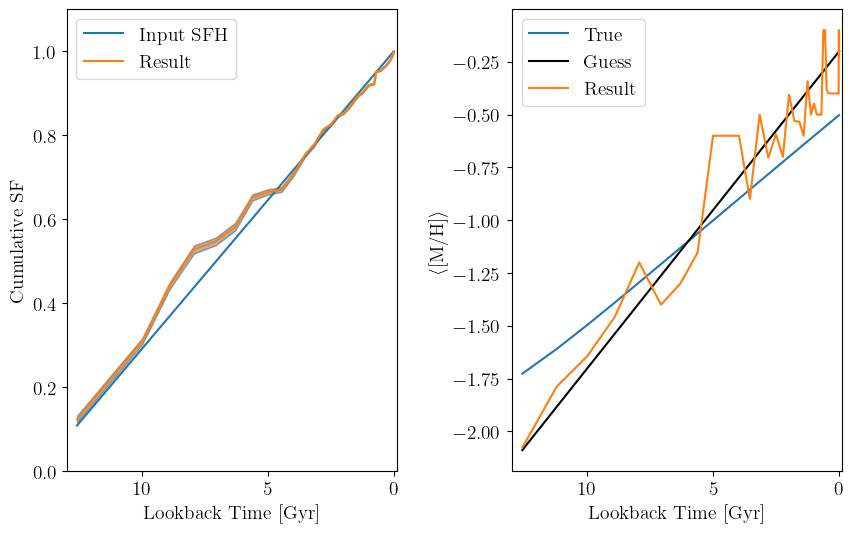

PyObject <matplotlib.legend.Legend object at 0x7f0402adfa30>

In [175]:
# Now plot cumulative SFH and MH evolution
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
# axs[1].plot( exp10.(unique_free_template_logAge)./1e9, cum_sfr_arr, label="Result" )
axs[1].plot( exp10.(unique_free_template_logAge)./1e9, hessian_cum_med, label="Result" )
axs[1].fill_between( exp10.(unique_free_template_logAge)./1e9, hessian_cum_lower, hessian_cum_upper, alpha=0.3, fc="k") 
axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="True" )
axs[2].plot( exp10.(unique_template_logAge)./1e9, met_func.(unique_template_logAge), c="k", label="Guess")
axs[2].plot( exp10.(unique_free_template_logAge)./1e9, free_mean_mh_arr, label="Result" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")
axs[2].legend()

We can additionally use the `Measurements.jl` package to estimate the uncertainties on the SFRs assuming that the `bfgs_result.map.σ` are Gaussian.

In [176]:
import Measurements: uncertainty, ±
hessian_sfrerr = uncertainty.(calculate_cum_sfr(bfgs_result.map.μ .± bfgs_result.map.σ,
                                                            free_template_logAge, free_template_MH; normalize_value=template_norm)[3]) .* 1e3

71-element Vector{Float64}:
 0.26866325531219126
 1.6258334122097537
 0.8081378030581212
 0.5867975849090303
 0.4682405693853463
 0.396338892282088
 0.35940004156590916
 0.3087309775832162
 0.2354980381826248
 0.1940813293753401
 0.18449767291494995
 0.1728507403181986
 0.23082921451776095
 ⋮
 0.07900891565455134
 0.08810072240019583
 0.045049805669357616
 0.09107398195285753
 0.1468789854512721
 0.15018786713288856
 0.08591938485066351
 0.10551505768162261
 0.18779723502386422
 0.07348438141116775
 0.06826954790549976
 0.1059225077699833

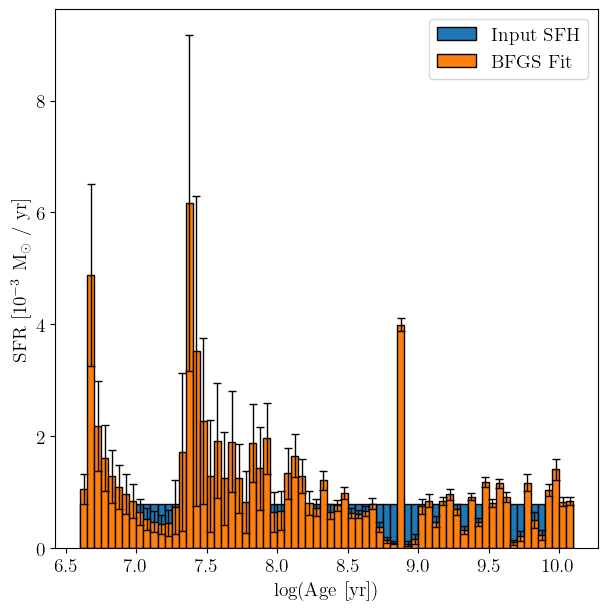

PyObject <matplotlib.legend.Legend object at 0x7f040299b880>

In [177]:
fig,ax1 = plt.subplots(figsize=(7,7))
ax1.bar(unique_template_logAge[begin:end-1], sfr_arr[begin:end-1] .* 1e3; width=diff(unique_template_logAge), align="edge", label="Input SFH")
# ax1.bar(unique_free_template_logAge[begin:end-1], free_sfr_arr[begin:end-1] .* 1e3; width=diff(unique_free_template_logAge), align="edge", yerr = hessian_sfrerr[begin:end-1], capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="LBFGS Fit")
ax1.bar(unique_free_template_logAge[begin:end-1], hessian_sfr_med[begin:end-1] .* 1e3; width=diff(unique_free_template_logAge), align="edge", yerr = hessian_sfrerr[begin:end-1], capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

The random errors here are underestimating the true uncertainty because there is a systematic error in the a priori metallicity evolution model by design. 

If we make the same plot with the `hessian_sfr_lower` and `hessian_sfr_upper` vectors, which utilize the samples from the full variance-covariance matrix, we see that the uncertainties look very similar across most of the plot, but are not identical due to the inclusion of covariance between parameters.

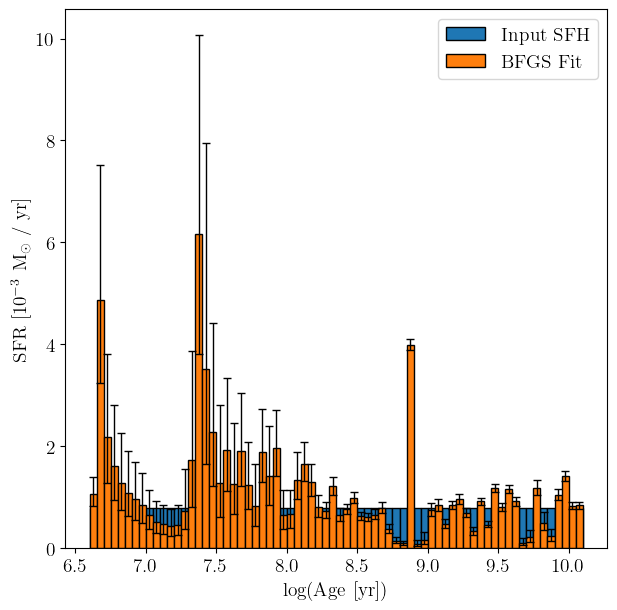

PyObject <matplotlib.legend.Legend object at 0x7f040277f9d0>

In [178]:
fig,ax1 = plt.subplots(figsize=(7,7))
ax1.bar(unique_template_logAge[begin:end-1], sfr_arr[begin:end-1] .* 1e3; width=diff(unique_template_logAge), align="edge", label="Input SFH")
ax1.bar(unique_free_template_logAge[begin:end-1], hessian_sfr_med[begin:end-1] .* 1e3; width=diff(unique_free_template_logAge), align="edge", 
    yerr = [(hessian_sfr_med[begin:end-1] .- hessian_sfr_lower[begin:end-1]) .* 1e3, 
            (hessian_sfr_upper[begin:end-1] .- hessian_sfr_med[begin:end-1]) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

Let us now compare to `hmc_sample`, which utilizes the No-U-Turn sampler variant of Hamiltonian Monte Carlo implemented in `DynamicHMC.jl` to sample from the posterior. This is a more rigorous way to obtain posterior samples than the method used above, but we will show that it gives very similar results.

In [183]:
import DynamicHMC
import StarFormationHistories: hmc_sample
mc_result = hmc_sample(free_templates, data, 10000; reporter=DynamicHMC.ProgressMeterReport())

Warmup: 100%|███████████████████████████████████████████| Time: 0:00:52
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:27
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:25
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:30
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:45
Warmup: 100%|███████████████████████████████████████████| Time: 0:01:08
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:11
MCMC: 100%|█████████████████████████████████████████████| Time: 0:23:06


(posterior_matrix = [-2.648369899664755 -0.5276910414633922 … -2.44324724551705 -1.4514020503620695; -2.0808827695322223 0.14155849726039554 … -0.11278294679678158 -1.0299382530185535; … ; 5.171617203092477 5.336439439995035 … 4.858855850706612 4.649229000742701; 5.9012826584017715 6.0720889928125406 … 5.813481277215892 6.138494521779294], tree_statistics = DynamicHMC.TreeStatisticsNUTS[DynamicHMC.TreeStatisticsNUTS(-12660.216138095442, 6, turning at positions -38:25, 0.9940304105345209, 63, DynamicHMC.Directions(0x81513ad9)), DynamicHMC.TreeStatisticsNUTS(-12699.860385021684, 6, turning at positions -8:55, 0.9729130521257139, 63, DynamicHMC.Directions(0x22dbf6b7)), DynamicHMC.TreeStatisticsNUTS(-12712.489086054793, 6, turning at positions -61:2, 0.9921651055380996, 63, DynamicHMC.Directions(0xdef0b802)), DynamicHMC.TreeStatisticsNUTS(-12729.422438891364, 6, turning at positions -8:55, 0.8830478573212067, 63, DynamicHMC.Directions(0x58b73f77)), DynamicHMC.TreeStatisticsNUTS(-12709.2078

We can check the summary statistics to ensure the samples have a high acceptance rate and are converging properly (turning % should be ~100%).

In [185]:
DynamicHMC.Diagnostics.summarize_tree_statistics(mc_result.tree_statistics)

Hamiltonian Monte Carlo sample of length 10000
  acceptance rate mean: 0.92, 5/25/50/75/95%: 0.73 0.88 0.95 0.98 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 100%

The parameters optimized by `full_templates` and `hmc_sample` are actually the logarithms of the coefficients, not the coefficients themselves, so we need to transform the samples here.

In [186]:
mc_matrix = exp.(mc_result.posterior_matrix) .* template_norm

284×10000 Matrix{Float64}:
     70.7665        589.966      …     86.8783       234.242
    124.82         1152.07            893.345        357.029
    620.882         625.166           765.274        197.223
   1927.93         2210.26           1909.59        2805.71
    588.635         151.831           152.509         84.8627
    192.486         507.659      …    203.016        202.003
    153.049         305.44             51.8132       219.075
   1566.78         1044.62           1271.84         931.812
    482.82          154.457            59.2155       300.462
    201.455         143.823            68.3793       395.185
    147.441          21.8431     …      6.92191       85.0794
      8.07143      1131.86            139.196        140.314
    307.549         196.347            49.0841       352.388
      ⋮                          ⋱                 
   9662.14         7940.04          16784.5         6879.87
   4657.34         6922.8           60327.1        37457.8
      2.

Calculate statistics from the MC samples.

In [188]:
# Calculate the cumulative SFH for each sample in the chain
# and find the 1-σ range
mc_cum_sfr = Vector{Vector{Float64}}(undef,0)
mc_sfr = Vector{Vector{Float64}}(undef,0)
for x in eachcol(mc_matrix)
    _, mc_1, mc_2, mc_mh = calculate_cum_sfr(x, free_template_logAge, free_template_MH)
    push!(mc_cum_sfr, mc_1)
    push!(mc_sfr, mc_2)
end
mc_cum_sfr = reduce(hcat, mc_cum_sfr) # hcat( mc_cum_sfr... )
mc_sfr = reduce(hcat, mc_sfr) # hcat( mc_sfr... )
# Calculate quantiles
mc_cum_lower = quantile.(eachrow(mc_cum_sfr), 0.16)
mc_cum_med = median.(eachrow(mc_cum_sfr))
mc_cum_upper = quantile.(eachrow(mc_cum_sfr), 0.84)
mc_sfr_lower = quantile.(eachrow(mc_sfr), 0.16)
mc_sfr_med = median.(eachrow(mc_sfr))
mc_sfr_upper = quantile.(eachrow(mc_sfr), 0.84)

71-element Vector{Float64}:
 0.0011204194925473307
 0.00538539933732933
 0.0023488486898290343
 0.0017405178019772028
 0.0013826919261523169
 0.001153326132197596
 0.001044391935291444
 0.0008969480801578838
 0.0007017138445670329
 0.000569874885286474
 0.0005194815364586544
 0.00047075621423203935
 0.0005773925466244413
 ⋮
 0.0012229366464859128
 0.0009955356384824367
 0.00012724309089753795
 0.00024720953881581843
 0.0012856501607544605
 0.0006170930013580317
 0.0002702739254612982
 0.001119633205624575
 0.0014222712834546193
 0.0008690889199192779
 0.0008942222893840744
 0.0009754325204151337

And we'll plot the cumulative SFHs:

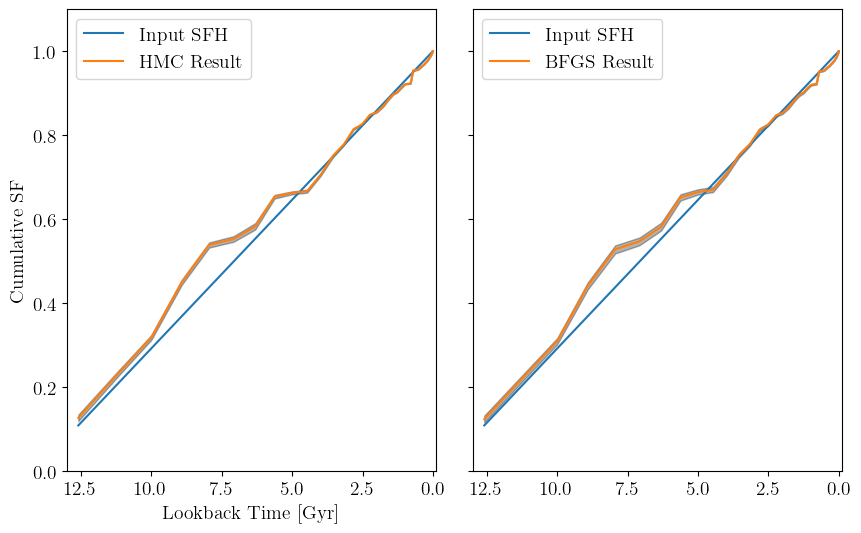

PyObject <matplotlib.legend.Legend object at 0x7f0401097df0>

In [202]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
axs[1].plot( exp10.(unique_free_template_logAge)./1e9, mc_cum_med, label="HMC Result" )
axs[1].fill_between( exp10.(unique_free_template_logAge)./1e9, mc_cum_lower, mc_cum_upper, alpha=0.3, fc="k") 

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
axs[2].plot( exp10.(unique_free_template_logAge)./1e9, hessian_cum_med, label="BFGS Result" )
axs[2].fill_between( exp10.(unique_free_template_logAge)./1e9, hessian_cum_lower, hessian_cum_upper, alpha=0.3, fc="k") 
axs[2].legend()

The differences are more obvious in the SFRs,

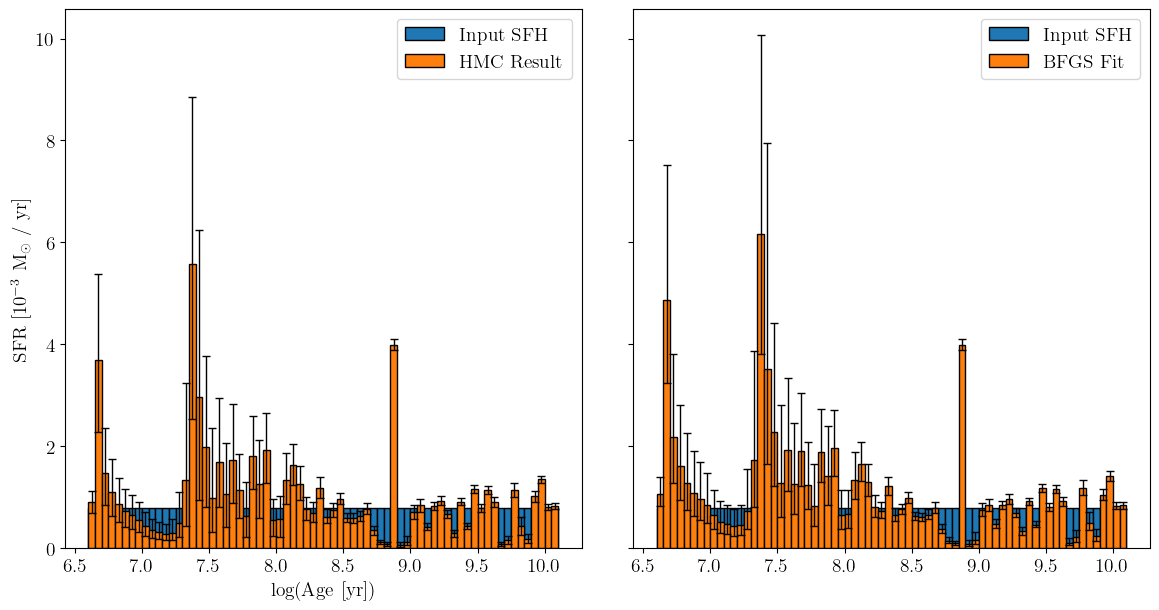

PyObject <matplotlib.legend.Legend object at 0x7f0400b89540>

In [204]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge[begin:end-1], sfr_arr[begin:end-1] .* 1e3; width=diff(unique_template_logAge), align="edge", label="Input SFH")
axs[1].bar(unique_free_template_logAge[begin:end-1], mc_sfr_med[begin:end-1] .* 1e3; width=diff(unique_free_template_logAge), align="edge", 
    yerr = [(mc_sfr_med[begin:end-1] .- mc_sfr_lower[begin:end-1]) .* 1e3, 
        (mc_sfr_upper[begin:end-1] .- mc_sfr_med[begin:end-1]) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="HMC Result")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, ax1.get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge[begin:end-1], sfr_arr[begin:end-1] .* 1e3; width=diff(unique_template_logAge), align="edge", label="Input SFH")
axs[2].bar(unique_free_template_logAge[begin:end-1], hessian_sfr_med[begin:end-1] .* 1e3; width=diff(unique_free_template_logAge), align="edge", 
    yerr = [(hessian_sfr_med[begin:end-1] .- hessian_sfr_lower[begin:end-1]) .* 1e3, 
            (hessian_sfr_upper[begin:end-1] .- hessian_sfr_med[begin:end-1]) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
axs[2].legend()

Thus the approximations we made above when deriving the uncertainties from the BFGS results that 
1. the posterior is well-approximated by a multivariate Gaussian in the fitting variables `θ = log(coeffs)` and 
2. the inverse Hessian approximation produced by the BFGS optimization is a good estimate of the variance-covariance matrix of said Gaussian

are not fully correct, but they are good enough in most cases that they can produce very similar posterior samples to the full HMC analysis at a fraction of the computational cost (a few seconds compared to minutes or hours). 